In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import datetime
import copy
import time

import sys
sys.path.append('../../')

from data.processing import get_data

import models

from main.seir.main import single_fitting_cycle
from main.seir.forecast import create_all_trials_csv, create_decile_csv_new
from utils.generic.create_report import save_dict_and_create_report
from utils.generic.config import read_config, make_date_key_str
from utils.generic.enums import Columns
from utils.fitting.loss import Loss_Calculator
from utils.generic.logging import log_wandb, log_mlflow
from viz import plot_forecast, plot_top_k_trials, plot_ptiles
from viz.uncertainty import plot_beta_loss

import yaml
import wandb

/Users/avtansht/anaconda3/envs/C19M/lib/python3.8/site-packages/wandb/util.py:35: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.9 it will stop working
  from collections import namedtuple, Mapping, Sequence


In [4]:
predictions_dict = {}

In [5]:
config_filename = 'mcmc.yaml'
config = read_config(config_filename)

wandb_config = read_config(config_filename, preprocess=False)
wandb_config = make_date_key_str(wandb_config)

In [6]:
timestamp = datetime.datetime.now()
output_folder = '../../misc/reports/{}'.format(timestamp.strftime("%Y_%m%d_%H%M%S"))

## Perform Fit

Performing fit ..
loading from ../../misc/cache/dataframes_ts_12032021_Covid19IndiaLoader.pkl


/Users/avtansht/anaconda3/envs/C19M/lib/python3.8/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


282 282


  0%|          | 6/2000 [00:00<00:38, 51.26it/s]

Smoothing 7358 recovered between 2020-05-28 and 2020-04-26 (32) days in a weighted-mag manner
Smoothing 3139 recovered between 2020-06-14 and 2020-04-26 (49) days in a weighted-mag manner
Smoothing 2432 recovered between 2020-06-23 and 2020-06-15 (8) days in a weighted-mag manner
Smoothing 2141 recovered between 2020-06-24 and 2020-06-15 (9) days in a weighted-mag manner
Smoothing 5900 recovered between 2020-07-01 and 2020-05-28 (34) days in a weighted-mag manner
Smoothing 917 deceased between 2020-06-15 and 2020-04-26 (50) days in a weighted-mag manner

splitting data ..
splitting data ..
train
 +-------------+---------------------+---------------------+---------------------+---------------------+---------------------+
|             | 120                 | 121                 | 122                 | 123                 | 124                 |
|-------------+---------------------+---------------------+---------------------+---------------------+---------------------|
| date        | 20

  0%|          | 9/2000 [00:00<00:24, 81.83it/s]

The acceptance ratio is -------->  0.2615
The explored steps are -------->  110
The optimized steps are -------->  413
Gelman-Rubin convergence statistics (variance ratios):
{   'E_hosp_ratio': 1.0620056369611452,
    'I_hosp_ratio': 1.1359927367944485,
    'P_fatal': 2.6523773814181113,
    'T_inc': 1.0611612723863375,
    'T_inf': 1.729238464127011,
    'T_recov': 1.8957793551765516,
    'T_recov_fatal': 1.1471188520083329,
    'gamma': 1.3566367958276946,
    'lockdown_R0': 1.1697274578364183}


100%|██████████| 2000/2000 [00:19<00:00, 104.92it/s]


> /Users/avtansht/Desktop/Desktop/Wadhwani/covid-modelling/main/seir/main.py(123)run_cycle()
-> print('best parameters\n', trials['params'][0])


(Pdb)  q


BdbQuit: 

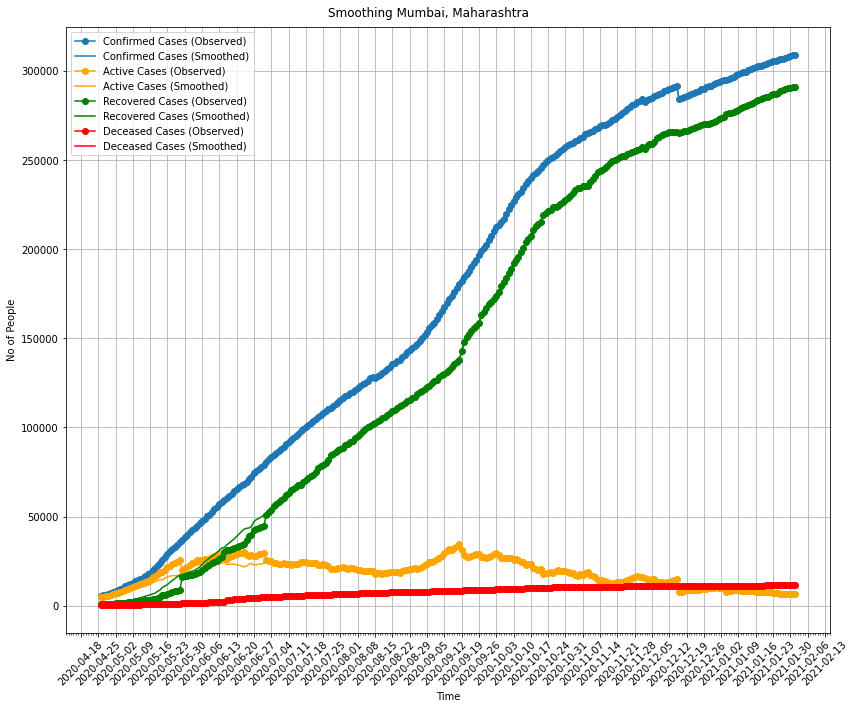

In [11]:
predictions_dict = single_fitting_cycle(**copy.deepcopy(config['fitting']))

## Loss Dataframe

In [ ]:
predictions_dict['df_loss']

## Plot Best Forecast

In [ ]:
predictions_dict['forecasts'] = {}
predictions_dict['forecasts']['best'] = predictions_dict['trials']['predictions'][0]

predictions_dict['plots']['forecast_best'] = plot_forecast(predictions_dict, 
                                                            config['fitting']['data']['dataloading_params']['location_description'],
                                                            which_compartments=config['fitting']['loss']['loss_compartments'],
                                                            error_bars=False)

## Process trials + Find best beta

In [ ]:
uncertainty_args = {'predictions_dict': predictions_dict, 'fitting_config': config['fitting'],
                     **config['uncertainty']['uncertainty_params']}
uncertainty = config['uncertainty']['method'](**uncertainty_args)

In [ ]:
predictions_dict['plots']['beta_loss'], _ = plot_beta_loss(uncertainty.dict_of_trials)

In [ ]:
uncertainty_forecasts = uncertainty.get_forecasts()
for key in uncertainty_forecasts.keys():
    predictions_dict['forecasts'][key] = uncertainty_forecasts[key]['df_prediction']
    
predictions_dict['forecasts']['ensemble_mean'] = uncertainty.ensemble_mean_forecast

## Plot Top k Trials

In [ ]:
kforecasts = plot_top_k_trials(predictions_dict, k=config['plotting']['num_trials_to_plot'],
                               which_compartments=config['plotting']['plot_topk_trials_for_columns'])
                               
predictions_dict['plots']['forecasts_topk'] = {}
for column in config['plotting']['plot_topk_trials_for_columns']:
    predictions_dict['plots']['forecasts_topk'][column.name] = kforecasts[column]

In [ ]:
predictions_dict['beta'] = uncertainty.beta
predictions_dict['beta_loss'] = uncertainty.beta_loss
predictions_dict['deciles'] = uncertainty_forecasts

## Plot Deciles Forecasts

In [ ]:
predictions_dict['plots']['forecast_best_50'] = plot_forecast(predictions_dict, 
                                                                    config['fitting']['data']['dataloading_params']['location_description'],
                                                                    which_compartments=config['fitting']['loss']['loss_compartments'],
                                                                    fits_to_plot=['best', 50], error_bars=False)
predictions_dict['plots']['forecast_best_80'] = plot_forecast(predictions_dict, 
                                                                    config['fitting']['data']['dataloading_params']['location_description'],
                                                                    which_compartments=config['fitting']['loss']['loss_compartments'],
                                                                    fits_to_plot=['best', 80], error_bars=False)
predictions_dict['plots']['forecast_ensemble_mean_50'] = plot_forecast(predictions_dict, 
                                                                             config['fitting']['data']['dataloading_params']['location_description'],
                                                                             which_compartments=config['fitting']['loss']['loss_compartments'],
                                                                             fits_to_plot=['ensemble_mean', 50], error_bars=False)

In [ ]:
ptiles_plots = plot_ptiles(predictions_dict, which_compartments=config['plotting']['plot_ptiles_for_columns'])
predictions_dict['plots']['forecasts_ptiles'] = {}
for column in config['plotting']['plot_ptiles_for_columns']:
    predictions_dict['plots']['forecasts_ptiles'][column.name] = ptiles_plots[column]

## Create Report

In [ ]:
save_dict_and_create_report(predictions_dict, config, ROOT_DIR=output_folder, config_filename=config_filename)

## Create Output CSV

In [ ]:
df_output = create_decile_csv_new(predictions_dict)
df_output.to_csv(f'{output_folder}/deciles.csv')

## Create All Trials Output

In [ ]:
df_all = create_all_trials_csv(predictions_dict)
df_all.to_csv(f'{output_folder}/all_trials.csv')

## Log on W&B

In [ ]:
wandb.init(project="covid-modelling", config=wandb_config)

In [ ]:
log_wandb(predictions_dict)

## Log on MLFlow

In [ ]:
log_mlflow(config['logging']['experiment_name'], run_name=config['logging']['run_name'], artifact_dir=output_folder)